Is it possible for a machine to group together similar data on its own? Absolutely&mdash;this is what clustering algorithms are all about. These algorithms fall under a branch of machine learning called **unsupervised learning**. In this branch, we give a machine an *unlabeled* training set containing data regarding the features but not the classes. Algorithms are left to their own devices to discover the underlying structure concealed within the data. This is in stark contrast to [supervised learning](http://machinemadephd.com/posts/building-logistic-regression/), where the correct answers are available and utilized to train a predictive model. 

In this post, I'd like to introduce an algorithm called **$k$-means clustering** and also construct one from scratch. Additionally, I'll demonstrate how this algorithm can be used automate an aspect of a widely used life sciences technique called **flow cytometry**.
<!-- TEASER_END -->

# Table of contents
1. [Inspecting the data](#cell1)
2. [Overview of $k$-means clustering](#cell2)
3. [Selecting the initial centroids](#cell3)
4. [Assigning each training example to a cluster](#cell4)
5. [Computing the updated centroids](#cell5)
6. [Minimizing the distortion function](#cell6)
7. [Training the clustering algorithm](#cell7)
8. [Implications and conclusions](#cell8)

<a id="cell1"></a>
# 1. Inspecting the data

Let's start by taking a look at the training set and its features.

In [1]:
# Load the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Improve readability of figures
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook', font_scale=1.4)

In [2]:
# Load the training set
features = pd.read_csv('data/immune_cells.csv')

# Display the first five rows
features.head()

,FSC,SSC
0,114500,104500
1,121500,119750
2,118250,115000
3,115750,118000
4,121000,108250


In [3]:
features.describe()

,FSC,SSC
count,3608.000000,3608.000000
mean,112164.426275,69779.101996
std,58579.733875,46192.509190
min,0.000000,0.000000
25%,74250.000000,31750.000000
50%,123500.000000,57250.000000
75%,155000.000000,106250.000000
max,250000.000000,250000.000000


It looks like we have 3608 training examples&mdash;each one is an individual [immune cell](https://en.wikipedia.org/wiki/Immune_system). These cells are primarily responsible for fighting bacteria, viruses, fungi and cancer. We also have two features: `FSC` and `SSC`. To better understand what these features entail, here's a brief introduction to flow cytometry. 

## A crash course in flow cytometry

Flow cytometry is a technique for measuring the distribution of specific cell types within a heterogenous pool of cells based on their structural properties and an unique array of biomarkers. The first step is to separate cells from each other using hydrodynamic focusing, ensuring a "single file line" of sorts. Next, each cell is individually interrogated by lasers of concrete wavelengths, resulting in the scattering of light and fluorescence, which is subsequently detected by photomultipliers. Flow cytometry analyses are typically performed on thousands or millions of cells, providing a plethora of training examples and being highly conducive for machine learning.

One measure of light scattering is called **forward scatter** (FSC)&mdash;its magnitude is proportional to the cell's volume. Another measure is called **side scatter** (SSC), which is proportional to the cell's structural complexity. Life scientists can classify certain cell types using these features alone, even without peeking into the biomarker signature. 

Immune cells are a popular candidate for flow cytometry analysis due to their myriad subsets. The broadest subsets are lymphocytes, monocytes and granulocytes, which are readily recognized by their FSC and SSC profiles. Life scientists can easily pick out these immune cell subsets using their extensive domain knowledge and past experience. The goal for today, however, is to ** train a machine to identify the major immune cell clusters on its own using only FSC and SSC data.** 

We'll be plotting the training set often so let's start by building a function that displays the data and any assigned clusters.

In [4]:
def plot_data(X, cluster_label):
    # Display a scatterplot and return the object
    return sns.lmplot(
        data=X,
        x=X.columns[0],
        y=X.columns[1],
        hue=cluster_label,
        fit_reg=False,
        legend=False,
        aspect=1.25,
        palette='Set2'
    )

Since we don't know the structure of the data yet, we need to set `cluster_label` to `None` when we plot the training set.

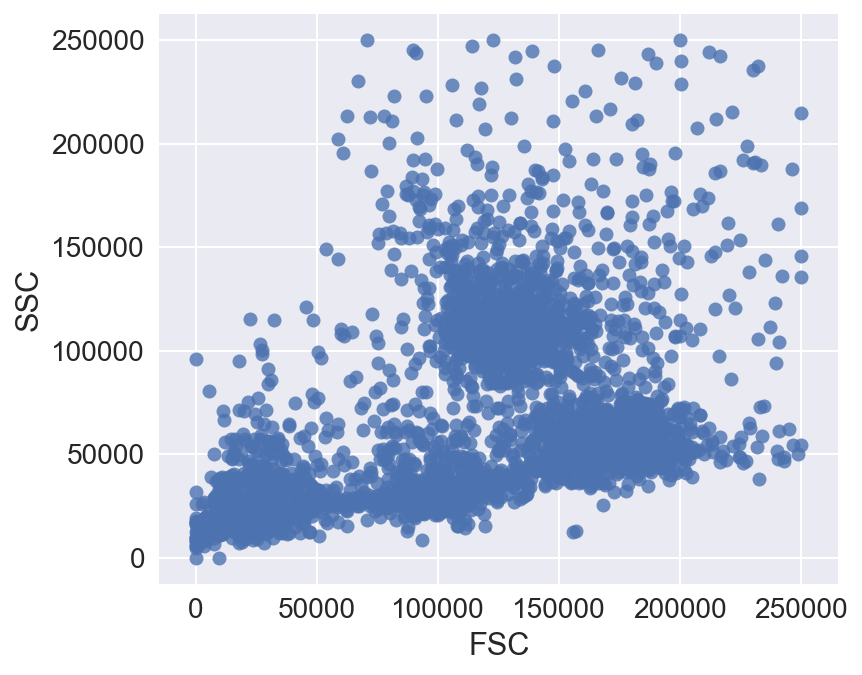

In [5]:
# Display a scatterplot of the training set without clusters
plot_data(features, None);

How many clusters do you see? Keep them in mind for now. 

Two quick notes before we proceed: first, these data are hypothetical but are representative of the FSC and SSC profile of immune cells from human blood. Second, let's normalize the data so the displayed numbers in later computations don't have a ridiculous number of digits.

In [6]:
# Perform feature normalization
features = (features - features.mean()) / features.std(ddof=0)

<a id="cell2"></a>
# 2. Overview of $k$-means clustering

The goal of this algorithm is to *automatically* group together similar training examples into clusters. First, we must choose a hyperparameter $k$ that specifies the number of clusters to detect. If we have context or prior knowledge about the data, we can pick the value of $k$ ourselves. Most of the time, however, the value of $k$ is ambiguous; in fact, we could dedicate an entire post to strategies for determining $k$. Because we already know the major immune cell subsets are lymphocytes, monocytes and granulocytes, we can set $k = 4$ (the one extra accounts for dead cells and debris&mdash;these have a similar light scatter profile).

In [7]:
# Select the number of clusters to detect
k = 4

Here's how the $k$-means clustering algorithm works:

1. Select an initial guess for the geometric center of each cluster, called a **centroid**
2. Assign each training example to a cluster by determining the nearest centroid
3. Compute new centroids using the mean position of all training examples assigned to each cluster
4. Repeat steps 2 and 3 until the new centroids barely differ in position from the previous centroids, i.e., the algorithm has converged to a set of centroids

These steps may seem convoluted at first but as we go through them, we'll soon find that this algorithm is quite intuitive.

<a id="cell3"></a>
# 3. Selecting the initial centroids

One way to guess the initial centroids is to pick $k$ random points. However, this runs the risk of picking centroids that aren't anywhere near the training set, which may delay convergence. A better idea is to randomly choose $k$ training examples as the initial centroids. Actually, there are more optimal options, but initialization strategies are a [separate topic](http://www.sciencedirect.com/science/article/pii/S0167865504000996) altogether. For our purposes, initializing centroids by randomly selecting $k$ training examples should be sufficient. 

In [8]:
def initialize_centroids(X, k):
    # Randomly sample the training set
    init_centroids = X.sample(n=k)
    
    # Re-label the index of each centroid from 1 to k
    init_centroids.index = np.arange(1, k + 1)
    return init_centroids

In [9]:
# Select the initial centroids
centroids = initialize_centroids(features, k)

# Display the initial centroids
centroids

,FSC,SSC
1,-1.590607,-1.251006
2,0.863653,0.464878
3,-0.766829,-0.655589
4,1.269140,1.255159


Let's also define a function to plot the centroids over each iteration of the algorithm.

In [10]:
def plot_centroids(figure, U):
    # Display a scatterplot of the centroids
    figure.ax.scatter(
        x=U['FSC'], 
        y=U['SSC'], 
        color='red', 
        marker='x'
    )

Let's see where the initial centroids lie within the training set. Again, since we haven't assigned any training examples to clusters yet, we have to set `cluster_label` to `None` when calling `plot_data()`.

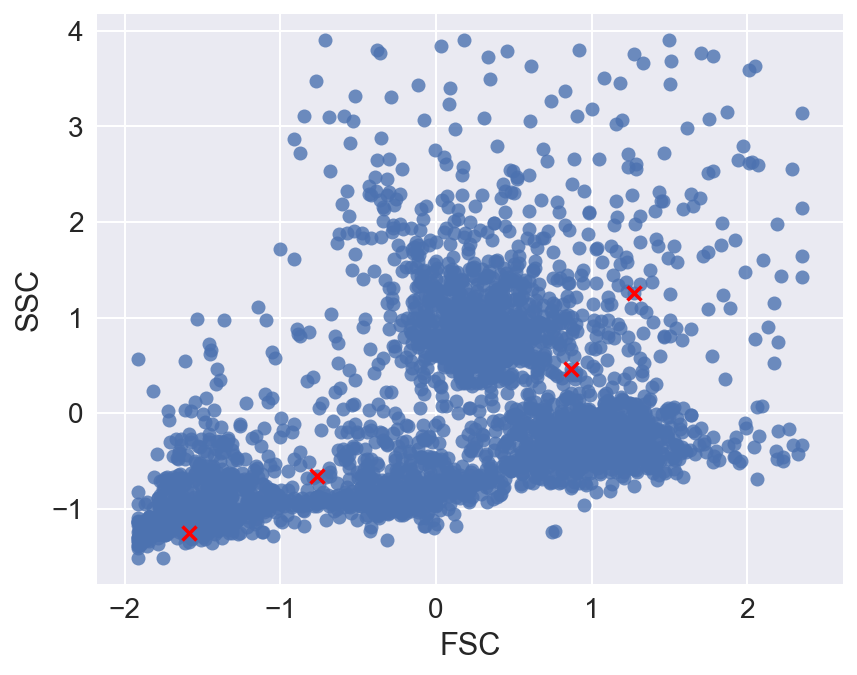

In [11]:
# Display a scatterplot of the training set without clusters
dot_plot = plot_data(features, None)

# Display the position of each centroid
plot_centroids(dot_plot, centroids)

<a id="cell4"></a>
# 4. Assigning each training example to a cluster

The next step is to assign every training example to one of the $k$ clusters. Because the centroid is the geometric center of a cluster, we perform this assignment by determining the centroid nearest to each training example, as measured by the square of the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

Specifically, for each training example $x^{(i)}$, we assign $c^{(i)} := j$ that minimizes $\lVert x^{(i)} - u_j \rVert ^2$ where $c^{(i)}$ is the label of the cluster whose centroid is nearest to $x^{(i)}$ and where $u_j$ is the position of the centroid for the $j$th cluster and $1 \leq j \leq k$. Let's build a function that performs this step.

In [12]:
def assign_clusters(X, U):
    # Record the number of training examples
    m = len(X)
    
    # Create a repository for recording the nearest centroids
    C = pd.DataFrame(np.empty(m), columns=['label'])
    
    # Identify the nearest centroid for each training example
    for (i, example) in X.iterrows():
        distance = (example - U).apply(np.linalg.norm, axis=1) 
        C.loc[i] = (distance ** 2).idxmin()
    return C

Let's assign training examples to clusters and then see what the clusters look like.

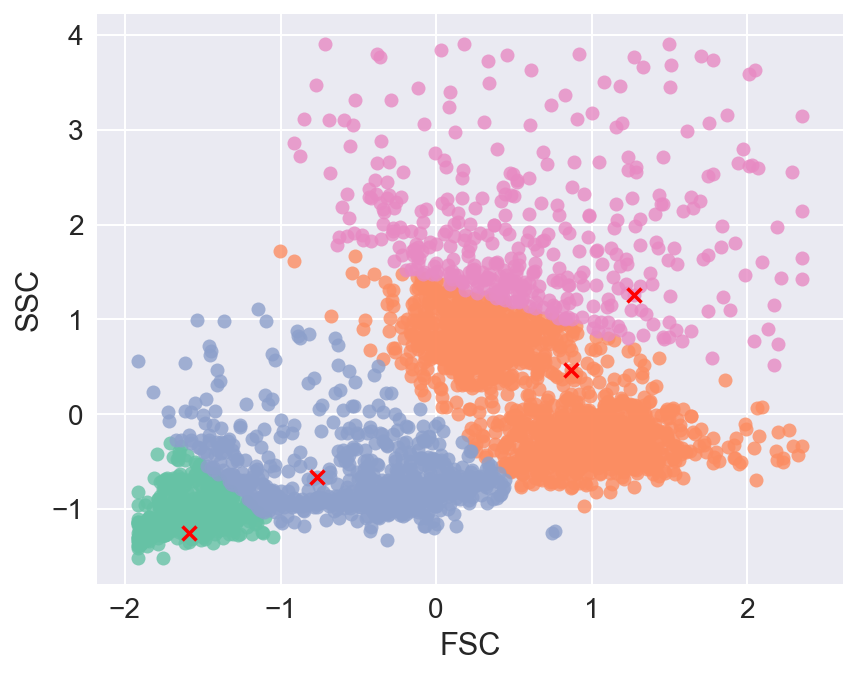

In [13]:
# Perform cluster assignment step
labels = assign_clusters(features, centroids)

# Display a scatterplot of the training set with clusters and centroids
dot_plot = plot_data(pd.concat((features, labels), axis=1), 'label')
plot_centroids(dot_plot, centroids)

Nothing exciting so far, but we're just getting started.

<a id="cell5"></a>
# 5. Computing the updated centroids

Having assigned every training example to a cluster, each cluster must therefore have a new centroid. To determine the positions of these new centroids, we compute the mean of all training examples assigned to each cluster, feature by feature.

Specifically, for each cluster $j$, we assign a new position for its centroid as given by

$$u_j := \frac{1}{\lvert c_j \rvert}\sum_{i \in c_j}x^{(i)}$$

where $c_j$ is the set of training examples assigned to cluster $j$. Let's build a function that performs this step.

In [14]:
def update_centroids(X, C):
    # Append cluster assignments to the features
    joined = pd.concat((X, C), axis=1)
    
    # Group training examples by cluster and compute the mean of each feature
    return joined.groupby('label').mean()

Let's update the centroids and then take a look at their new positions.

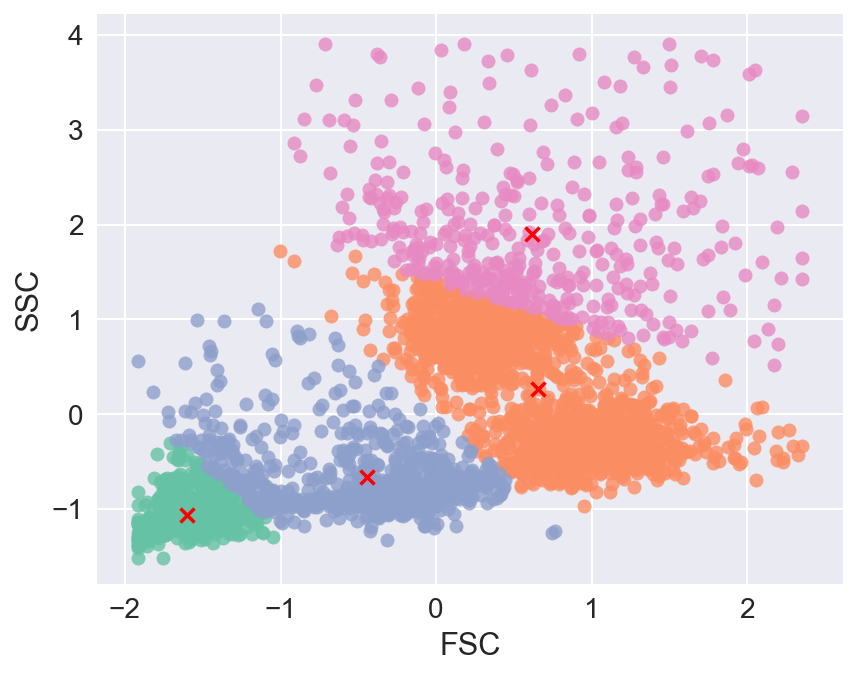

In [15]:
# Perform centroid update step
centroids = update_centroids(features, labels)

# Display a scatterplot of the training set with clusters and centroids
dot_plot = plot_data(pd.concat((features, labels), axis=1), 'label')
plot_centroids(dot_plot, centroids)

The centroids are on the move but this is only the first iteration&mdash;we still have ways to go. However, we don't have any way to determine whether the algorithm has converged to a set of centroids.

<a id="cell6"></a>
# 6. Minimizing the distortion function 

We can measure how tightly clustered the data are using the sum of the squared Euclidean distance between each training example and the centroid of its currently assigned cluster. This metric is called the **distortion function** and is given by

$$J(c^{(i)}, u_j) = \sum_{i=1}^m{\lVert x^{(i)} - u_{c^{(i)}} \rVert ^2}$$

where $m$ is the total number of training examples. The tighter the clustering, the smaller the value of $J$. In fact, $J$ converging to a minimum is a good indicator that the algorithm has converged to a set of centroids. **Therefore, the goal of the $k$-means clustering algorithm is to minimize the distortion function.**

In [16]:
def distortion_function(X, U, C):
    # Compute the sum of the squared distances between each training example 
    # and the centroid of its currently assigned cluster
    return sum(np.linalg.norm(example - U.loc[C.loc[i]]) ** 2
               for (i, example) in X.iterrows())

<a id="cell7"></a>
# 7. Training the clustering algorithm

We're now prepped to train the algorithm and learn the structure of the training set. Let's start with a fresh set of initial centroids, and repeat the cluster assignment and centroid update steps for 5 iterations.

In [17]:
# Set the number of iterations
iterations = 5

# Select the initial centroids
centroids = initialize_centroids(features, k)

# Create a repository for recording the distortion function at each iteration
distortion_history = np.empty(iterations)

# Perform k-means clustering on the training set
for i in range(iterations):
    labels = assign_clusters(features, centroids)
    centroids = update_centroids(features, labels)
    distortion_history[i] = distortion_function(features, centroids, labels)

We've now learned the clusters in the training set so let's see what they look like.

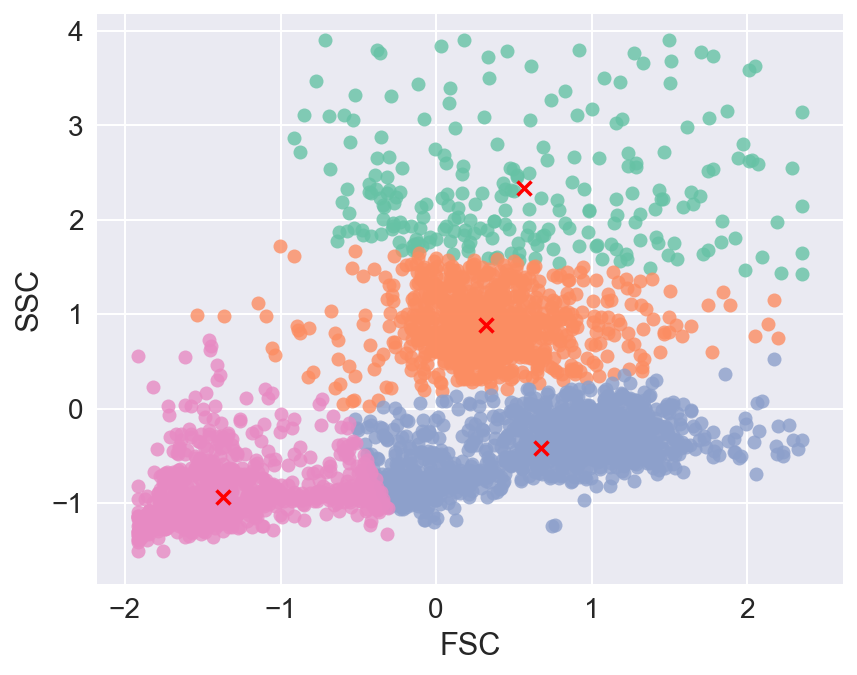

In [18]:
# Display a scatterplot of the training set with clusters and centroids
dot_plot = plot_data(pd.concat((features, labels), axis=1), 'label')
plot_centroids(dot_plot, centroids)

Does the clustering match with what you had in mind? It looks pretty off to me. Let's inspect the distortion function at each iteration to determine if the algorithm converged to a set of centroids.

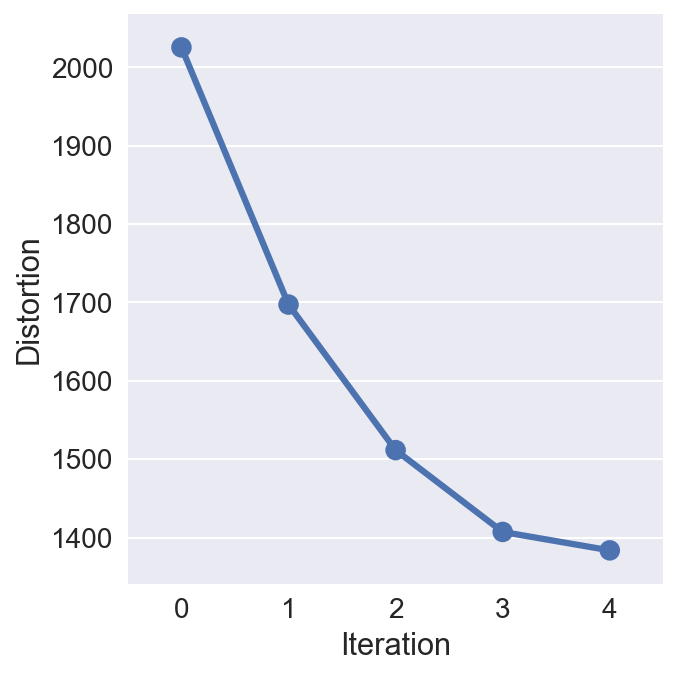

In [19]:
# Display a scatterplot of the distortion function after each iteration
sns.factorplot(
    x='Iteration',
    y='Distortion',
    data=pd.DataFrame(
        {'Iteration': range(iterations), 'Distortion': distortion_history}
    ),
    fit_reg=False,
    size=5
);

It looks like the distortion function is still decreasing&mdash;the algorithm has yet to converge, which explains the suboptimal clustering. We could try retraining the algorithm with additional iterations; however, perhaps the choice of initial centroids was subpar to begin with.

## How to avoid local minima for the distortion function

It turns out the distortion function is [non-convex](http://math.stackexchange.com/questions/463453/how-to-see-that-k-means-objective-is-convex); that is, depending on the choice of initial centroids, the algorithm may get stuck in a local minimum and yield suboptimal clustering. One way to avoid this issue altogether is to train the algorithm several times using a new choice of initial centroids each time. Afterwards, we choose the clustering that yields the lowest distortion.

In [20]:
# Initialize the current lowest distortion
lowest_distortion = 10 ** 10

# Train the algorithm several times
for _ in range(10):
    # Select the initial centroids
    centroids = initialize_centroids(features, k)
    
    # Perform k-means clustering on the training set
    for _ in range(iterations):
        labels = assign_clusters(features, centroids)
        centroids = update_centroids(features, labels)
    
    # Record the clustering that yields the lowest distortion
    curr_distortion = distortion_function(features, centroids, labels)
    if curr_distortion < lowest_distortion:
        lowest_distortion = curr_distortion
        opt_labels = labels
        opt_centroids = centroids

Let's take a look at the distortion function of the optimal clustering and then visualize the learned clusters.

In [21]:
distortion_function(features, opt_centroids, opt_labels)

1285.7892786755242

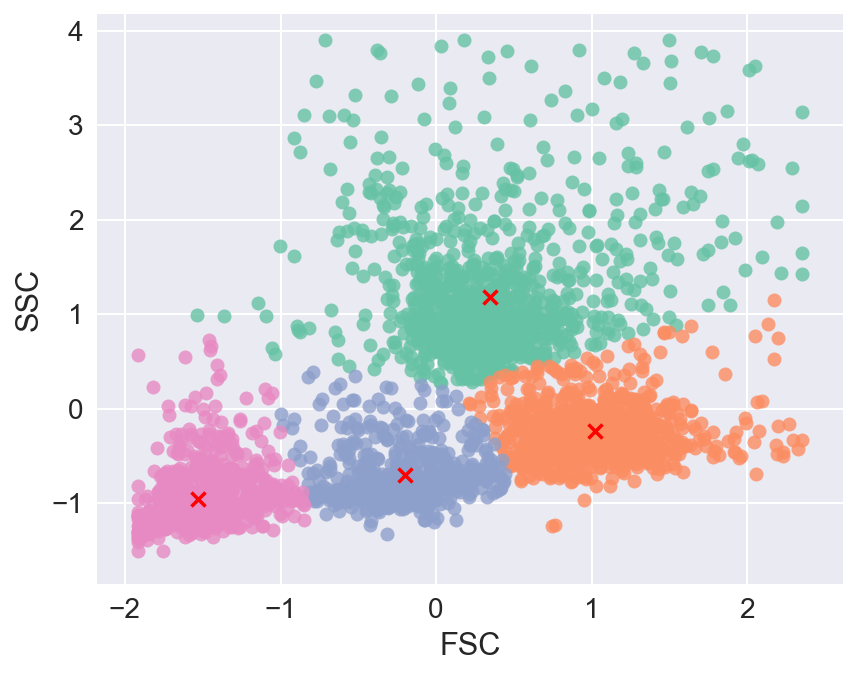

In [22]:
# Display a scatterplot of the training set with clusters and centroids
dot_plot = plot_data(pd.concat((features, opt_labels), axis=1), 'label')
plot_centroids(dot_plot, opt_centroids)

What an improvement! In fact, as someone who has performed this grouping *manually* hundreds of times, I can attest that these clusters lie very close to the natural positions of the major immune cell subsets:
- Pink are dead cells or debris
- Violet are lymphocytes
- Orange are monocytes
- Green are granulocytes

Let's now compare our homemade algorithm to a highly optimized one from Scikit-learn.

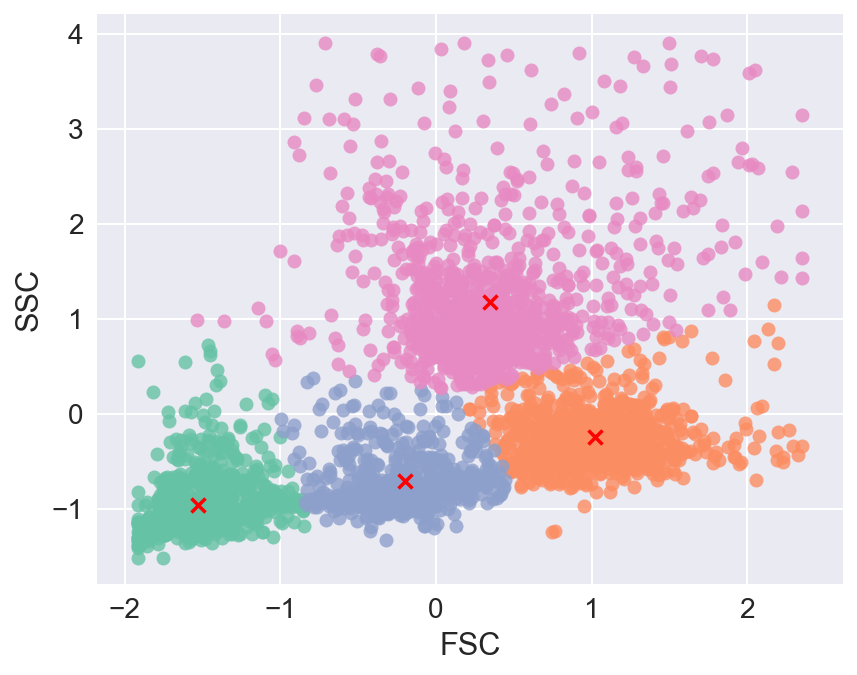

In [23]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the training set
kmeans = KMeans(n_clusters=k).fit(features)

# Extract the optimal clusters and centroids
opt_labels2 = pd.DataFrame(kmeans.labels_, columns=['label'])
opt_centroids2 = pd.DataFrame(kmeans.cluster_centers_, columns=['FSC', 'SSC'])

# Display a scatterplot of the training set with clusters and centroids
dot_plot = plot_data(pd.concat((features, opt_labels2), axis=1), 'label')
plot_centroids(dot_plot, opt_centroids2);

Let's also compute the distortion function of this clustering.

In [24]:
distortion_function(features, opt_centroids2, opt_labels2)

1285.7892786755244

The colors are swapped but the clustering is very similar. In fact, the value of the distortion function is nearly identical to that of our homemade algorithm. Not bad at all!

<a id="cell8"></a>
# 8. Implications and conclusions

Using $k$-means clustering, we learned the underlying structure of raw, unlabeled data and successfully identified the four clusters in the training set. This result may seem trivial; indeed, most people could have picked out these clusters without much effort. Perhaps that's what makes this result so intriguing&mdash;**a machine can identify a pattern just like a human.**

For simplicity's sake, we used a training set with two features in this example, but real-world datasets can have hundreds or thousands. Manually identifying clusters from these high-dimensional datasets is infeasible; whereas, a clustering algorithm can handle this task with aplomb. In fact, most flow cytometry analyses involve a multitude of features in addition to FSC and SSC such as fluorescence intensities from antibodies that target the cell's unique biomarker signature. 

Solely relying on prior knowledge or a hunch to select $k$ isn't ideal. As humans, we naturally seek patterns and sometimes discover them [where there exist none](https://en.wikipedia.org/wiki/Pareidolia). This is especially worrisome in research environments where there is a prevalence of [confirmation bias](https://en.wikipedia.org/wiki/Confirmation_bias) that can lead to irreproducible results or even worse, incorrect conclusions. Fortunately, there are [numerous methods](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) that help us choose $k$ programatically. Nevertheless, keep in mind that clustering algorithms will find clusters even if none exist. **Therefore, it's crucial to combine prior knowledge, an analytical approach, and even common sense to select $k$.** 

For most flow cytometry analyses, life scientists will manually "gate" around where they visually spot a cluster. Not surprisingly, this process is highly subjective, onerous, and leaves room for false positives and negatives. The recent rise of machine learning has sparked a [movement](http://www.nature.com/nri/journal/v16/n7/full/nri.2016.56.html) towards automated methodologies for flow cytometry analysis. In fact, [one group](http://www.nature.com/articles/srep21471) utilized various classifiers, such as support vector machines and deep neural nets, to successfully distinguish T lymphocytes (a type of immune cell) from colon cancer cells *without* labeling them with antibodies. Since flow cytometry is commonly used for diagnostics, I wouldn't be surprised if this approach dramatically shrinks the cost of these tests and their turnaround time in the future.

By now you should have a strong foundation on the $k$-means clustering algorithm. I also hope this tutorial helped you appreciate the power of clustering algorithms and unsupervised learning. These algorithms are being applied in a vast array of fields such as genetics, geology, medical imaging, ecology, criminology, robotics, climatology, astronomy, market research, etc.&mdash;the list is growing rapidly! I'm always excited to see the next application and am eager to get involved.

If you have any comments, questions or suggestions, kindly visit the [blog post](http://inmachineswetrust.com/posts/k-means_clustering/) associated with this analysis.